<a href="https://colab.research.google.com/github/declanc2001/AITrainer/blob/main/GolfAITakeTWO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip -q install --upgrade pip
!pip -q install "numpy<2" "protobuf<5" --upgrade
!pip -q install opencv-python-headless numpy
!pip -q install mediapipe==0.10.15
print("✅ Installed OpenCV, NumPy, MediaPipe")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 30.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
pytensor 2.36.3 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 4.25.8 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
grain 0.2.15 requires protobuf>=5.28.3, but you have prot

In [1]:
import numpy as np
import mediapipe as mp
import cv2

print("numpy:", np.__version__)
print("mediapipe:", mp.__version__)
print("opencv:", cv2.__version__)
print("has mp.solutions?", hasattr(mp, "solutions"))
mp_pose = mp.solutions.pose
print("✅ mp.solutions.pose works")


numpy: 1.26.4
mediapipe: 0.10.15
opencv: 4.11.0
has mp.solutions? True
✅ mp.solutions.pose works


In [7]:
from google.colab import files
uploaded = files.upload()

video_path = list(uploaded.keys())[0]
print("✅ Uploaded:", video_path)


Saving Swing2.mp4 to Swing2.mp4
✅ Uploaded: Swing2.mp4


In [8]:
import cv2
import mediapipe as mp
import pandas as pd

mp_pose = mp.solutions.pose

def extract_pose_timeseries(video_path, max_frames=None):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS) or 30.0

    pose = mp_pose.Pose(static_image_mode=False)

    rows = []
    frame_idx = 0

    while True:
        ok, frame = cap.read()
        if not ok:
            break

        # Optional: stop early if you only want to test quickly
        if max_frames is not None and frame_idx >= max_frames:
            break

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(rgb)

        if results.pose_landmarks:
            lm = results.pose_landmarks.landmark

            def xy(point_enum):
                p = lm[point_enum]
                return p.x, p.y

            lsx, lsy = xy(mp_pose.PoseLandmark.LEFT_SHOULDER)
            rsx, rsy = xy(mp_pose.PoseLandmark.RIGHT_SHOULDER)
            lhx, lhy = xy(mp_pose.PoseLandmark.LEFT_HIP)
            rhx, rhy = xy(mp_pose.PoseLandmark.RIGHT_HIP)

            rows.append({
                "frame": frame_idx,
                "time_sec": frame_idx / fps,
                "ls_x": lsx, "ls_y": lsy,
                "rs_x": rsx, "rs_y": rsy,
                "lh_x": lhx, "lh_y": lhy,
                "rh_x": rhx, "rh_y": rhy,
            })

        frame_idx += 1

    cap.release()
    return pd.DataFrame(rows), fps

# Run it (max_frames=None means "whole video")
df_pose, fps = extract_pose_timeseries(video_path, max_frames=None)

print("fps:", fps)
print("rows (frames with pose detected):", len(df_pose))
df_pose.head()


/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


fps: 30.0
rows (frames with pose detected): 61


,frame,time_sec,ls_x,ls_y,rs_x,rs_y,lh_x,lh_y,rh_x,rh_y
0,0,0.000000,0.521054,0.400349,0.523730,0.414986,0.467229,0.531954,0.464505,0.540331
1,1,0.033333,0.519828,0.399979,0.523906,0.415155,0.467110,0.532217,0.464827,0.541190
2,2,0.066667,0.519208,0.399932,0.524149,0.415369,0.466837,0.532219,0.464893,0.541258
3,3,0.100000,0.518978,0.399959,0.524341,0.415166,0.466574,0.532193,0.464872,0.541107
4,4,0.133333,0.518763,0.399960,0.524397,0.415114,0.466399,0.532189,0.464834,0.540997


   time_sec  shoulder_turn_deg
0  0.000000          28.380239
1  0.033333          29.314023
2  0.066667          29.886327
3  0.100000          30.234453
4  0.133333          30.465631


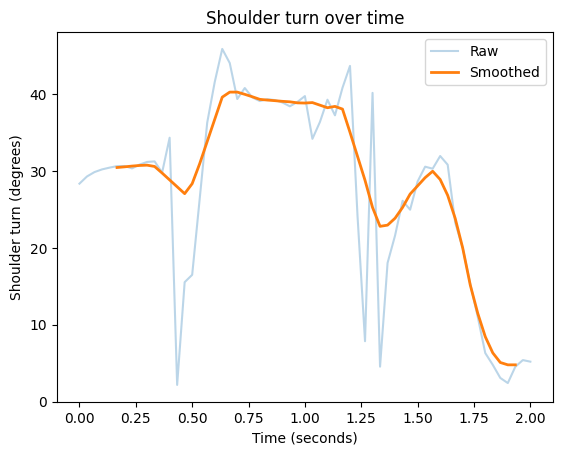

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def angle_between(v1, v2):
    v1 = np.array(v1); v2 = np.array(v2)
    dot = np.dot(v1, v2)
    denom = (np.linalg.norm(v1) * np.linalg.norm(v2))
    if denom == 0:
        return np.nan
    cos = np.clip(dot / denom, -1.0, 1.0)
    return np.degrees(np.arccos(cos))

shoulder_angles = []

for _, r in df_pose.iterrows():
    shoulder_vec = np.array([r["ls_x"] - r["rs_x"], r["ls_y"] - r["rs_y"]])
    hip_vec      = np.array([r["lh_x"] - r["rh_x"], r["lh_y"] - r["rh_y"]])
    shoulder_angles.append(angle_between(shoulder_vec, hip_vec))

df_pose["shoulder_turn_deg"] = shoulder_angles


df_pose["shoulder_turn_smooth"] = (
    df_pose["shoulder_turn_deg"]
    .rolling(window=7, center=True)
    .median()
)

diff = df_pose["shoulder_turn_smooth"].diff().abs()
df_pose.loc[diff > 25, "shoulder_turn_smooth"] = np.nan
df_pose["shoulder_turn_smooth"] = df_pose["shoulder_turn_smooth"].interpolate()

# extra gentle smoothing to remove “steps”
df_pose["shoulder_turn_smooth"] = (
    df_pose["shoulder_turn_smooth"]
    .rolling(window=5, center=True)
    .mean()
)





print(df_pose[["time_sec", "shoulder_turn_deg"]].head())

# Plot shoulder turn over time
plt.figure()
plt.plot(df_pose["time_sec"], df_pose["shoulder_turn_deg"], alpha=0.3, label="Raw")
plt.plot(df_pose["time_sec"], df_pose["shoulder_turn_smooth"], linewidth=2, label="Smoothed")
plt.xlabel("Time (seconds)")
plt.ylabel("Shoulder turn (degrees)")
plt.title("Shoulder turn over time")

plt.legend()
plt.show()
